<a href="https://colab.research.google.com/github/chatwipa-sur/SRCC_detection/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [1]:
# !pip install pascal-voc-writer lxml

In [31]:
# Library for directory actions (file handling, path operations)
import os
import json
import random
import shutil

# Library for XML parsing (used to read annotation files)
import xml.etree.ElementTree as ET

# Library for collecting data in dictionary-like objects
from collections import defaultdict

# Library for image processing and visualization
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Library for data manipulation and annotation parsing
import pandas as pd

# PyTorch library
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from torch.utils.data import random_split

# Library for numerical computations
import numpy as np

## 1. Data Exploration

In [3]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1 Positive image

In [4]:
# Annotation folder path
annotation_path = "/content/drive/MyDrive/Dissertation_Chatwipa/temp_dataset/positive_annotation"

# List XML files
xml_files = [f for f in os.listdir(annotation_path) if f.endswith('.xml')]
print(f"Found {len(xml_files)} XML files")

# Print a few filenames
for item in xml_files[:5]:
  print(item)

Found 77 XML files
2018_67251_1-13_2019-02-26 00_53_32-lv0-5957-15182-2033-2041.xml
2018_69188_1-1_2019-03-14 23_40_58-lv0-63809-55942-2041-2070.xml
D201803347_2019-05-21 19_31_10-lv0-34945-46364-2008-2084.xml
G1900703-2_2019-04-30 09_53_59-lv0-6630-14336-2073-2073.xml
D20180627801_2019-05-21 18_40_34-lv0-12112-37198-2058-2042.xml


In [5]:
# Explore a annotation file
sample_file = os.path.join(annotation_path, xml_files[0])
tree = ET.parse(sample_file)
root = tree.getroot()
filename = root.find('filename').text
size = root.find('size')
width = int(size.find('width').text)
height = int(size.find('height').text)
print(f"File: {filename}, Size: {width}x{height}")

# Extract all object info
print(f"Number of object: {len(root.findall('object'))}")
for obj in root.findall('object')[:3]:
  label = obj.find('name').text
  bbox = obj.find('bndbox')
  xmin = int(bbox.find('xmin').text)
  ymin = int(bbox.find('ymin').text)
  xmax = int(bbox.find('xmax').text)
  ymax = int(bbox.find('ymax').text)
  print(f"Label: {label}, BBox: ({xmin}, {ymin}, {xmax}, {ymax})")

File: 2018_67251_1-13_2019-02-26 00_53_32-lv0-5957-15182-2033-2041.jpeg, Size: 2033x2041
Number of object: 211
Label: ring_cell_cancer, BBox: (118, 88, 170, 133)
Label: ring_cell_cancer, BBox: (344, 106, 389, 153)
Label: ring_cell_cancer, BBox: (758, 25, 795, 69)


In [6]:
# Class in the annotation file
class_counts = defaultdict(int)
for xml_file in xml_files:
  file_path = os.path.join(annotation_path, xml_file)
  root = ET.parse(file_path).getroot()
  for obj in root.findall('object'):
    label = obj.find('name').text
    class_counts[label] += 1

for label, count in class_counts.items():
  print(f"{label}: {count}")

ring_cell_cancer: 9710


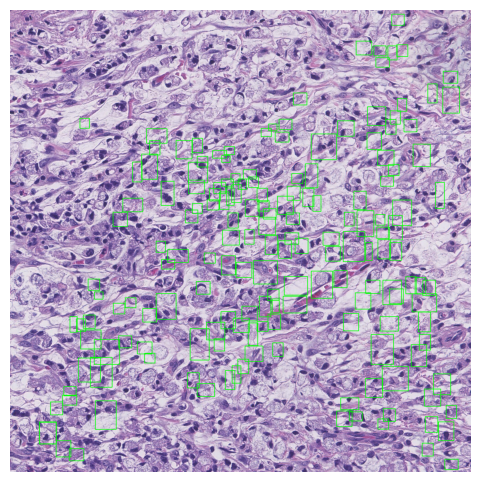

In [7]:
# Example positive image
image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/temp_dataset/sig-train-pos/"
image_file = os.path.join(image_dir, filename)

img = cv2.imread(image_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for obj in root.findall('object'):
    label = obj.find('name').text
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Split train and test images

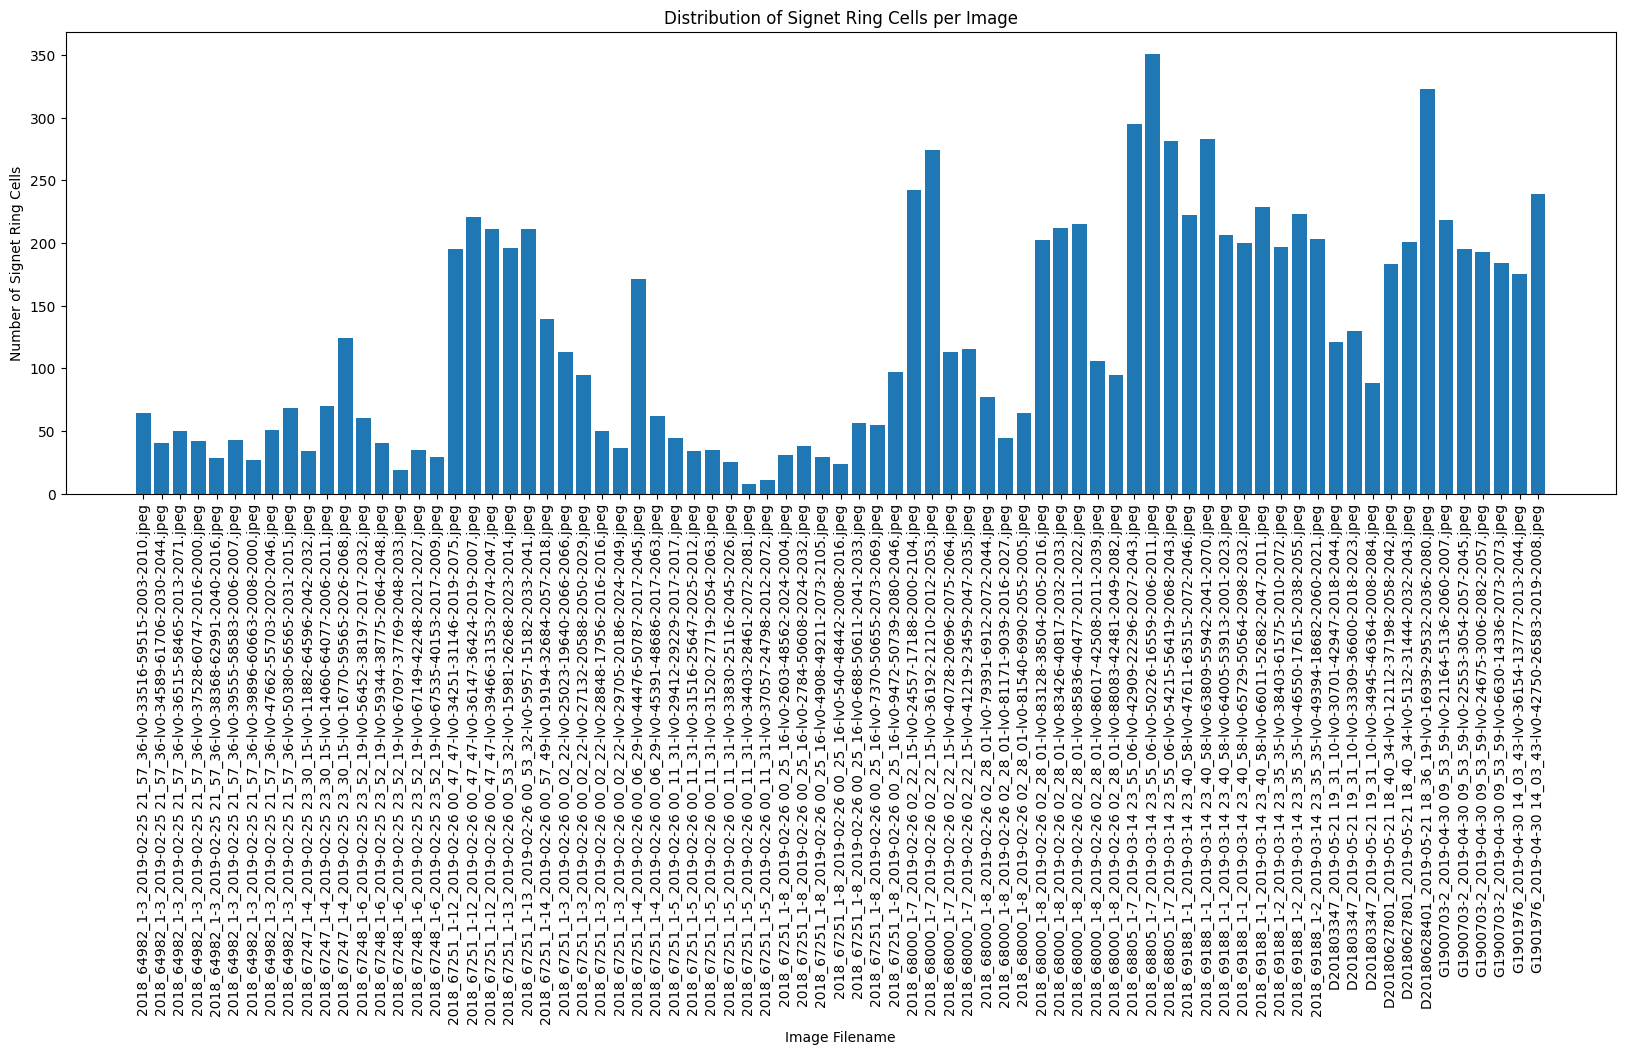

In [8]:
# Distribution of signet ring cell in each images
src_counts_per_img = defaultdict(int)
for xml_file in xml_files:
  file_path = os.path.join(annotation_path, xml_file)
  root = ET.parse(file_path).getroot()
  filename = root.find('filename').text
  for obj in root.findall('object'):
    label = obj.find('name').text
    if label == 'ring_cell_cancer':
      src_counts_per_img[filename] += 1

# Plot the number of signet ring cell in each image
sorted_filenames = sorted(src_counts_per_img.keys())
sorted_counts = [src_counts_per_img[f] for f in sorted_filenames]
plt.figure(figsize=(20, 6))
plt.bar(sorted_filenames, sorted_counts)
plt.xlabel("Image Filename")
plt.ylabel("Number of Signet Ring Cells")
plt.title("Distribution of Signet Ring Cells per Image")
plt.xticks(rotation=90)
plt.show()

In [9]:
# Select 80% (61 images) for training and 20% (16 images) for testing
src_less_than_50 = {key: value for key, value in src_counts_per_img.items() if value <= 50}
print(f"Number of images with less than 50 ring cells: {len(src_less_than_50)}")
src_50_100 = {key: value for key, value in src_counts_per_img.items() if 50 < value <= 100}
print(f"Number of images with 50-100 ring cells: {len(src_50_100)}")
src_100_200 = {key: value for key, value in src_counts_per_img.items() if 100 < value <= 200}
print(f"Number of images with 100-200 ring cells: {len(src_100_200)}")
src_more_than_200 = {key: value for key, value in src_counts_per_img.items() if value > 200}
print(f"Number of images with more than 200 ring cells: {len(src_more_than_200)}")

Number of images with less than 50 ring cells: 24
Number of images with 50-100 ring cells: 14
Number of images with 100-200 ring cells: 18
Number of images with more than 200 ring cells: 21


In [10]:
# Training set
train_name = list(src_less_than_50.keys())[:-4] + list(src_50_100.keys())[:-4]+list(src_100_200.keys())[:-4]+list(src_more_than_200.keys())[:-4]
print(f'Number of train images: {len(train_name)}')

# with open('/content/drive/MyDrive/Dissertation_Chatwipa/temp_dataset/pos_train.txt', 'w') as f:
#   for name in train_name:
#     f.write(f"{name}\n")

Number of train images: 61


In [11]:
# Testing set
test_name = list(src_less_than_50.keys())[-4:] + list(src_50_100.keys())[-4:]+list(src_100_200.keys())[-4:]+list(src_more_than_200.keys())[-4:]
print(f'Number of test images: {len(test_name)}')

# with open('/content/drive/MyDrive/Dissertation_Chatwipa/temp_dataset/pos_test.txt', 'w') as f:
#   for name in test_name:
#     f.write(f"{name}\n")

Number of test images: 16


### 1.2 Negative image

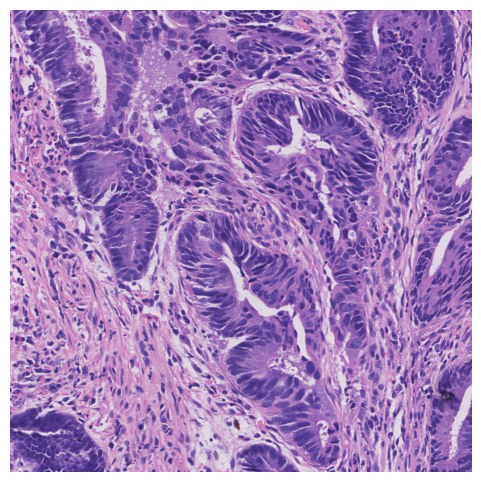

In [12]:
# Example negative image
image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/temp_dataset/sig-train-neg/"
filename = "18-36771A_2019-05-08 22_29_28-lv0-40882-42749-2000-2000.jpeg"
image_file = os.path.join(image_dir, filename)
img = cv2.imread(image_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Split train and test image

In [13]:
# Path to the negative image directory
neg_image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/temp_dataset/sig-train-neg/"

# List all files in the negative image directory
neg_image_files = [f for f in os.listdir(neg_image_dir) if os.path.isfile(os.path.join(neg_image_dir, f))]
print(f"Found {len(neg_image_files)} negative image files")

Found 379 negative image files


In [14]:
# Select 80% (303 images) for training and 20% (76 images) for testing
random.shuffle(neg_image_files)
neg_train_files = neg_image_files[:303]
neg_test_files = neg_image_files[303:]

# with open('/content/drive/MyDrive/Dissertation_Chatwipa/temp_dataset/neg_train.txt', 'w') as f:
#   for name in neg_train_files:
#     f.write(f"{name}\n")

# with open('/content/drive/MyDrive/Dissertation_Chatwipa/temp_dataset/neg_test.txt', 'w') as f:
#   for name in neg_test_files:
#     f.write(f"{name}\n")

## 2. Create dataset folders

```
dataset/
├── train/
│   ├── pos/
│   └── neg/
├── test/
│   ├── pos/
│   └── neg/
└── annotations/
    ├── train/
    │   ├── pos/
    │   └── neg/
    └── test/
        ├── pos/
        └── neg/
```


### 2.1 Move images into train and test folders

In [15]:
# Define the base directory
dataset_base_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset"

# Define the paths for the training and testing directories
train_images_pos_dir = os.path.join(dataset_base_dir, "train", "positive")
train_images_neg_dir = os.path.join(dataset_base_dir, "train", "negative")
test_images_pos_dir = os.path.join(dataset_base_dir, "test", "positive")
test_images_neg_dir = os.path.join(dataset_base_dir, "test", "negative")


train_annotations_pos_dir = os.path.join(dataset_base_dir, "annotations", "train","positive")
train_annotations_neg_dir = os.path.join(dataset_base_dir, "annotations", "train","negative")
test_annotations_pos_dir = os.path.join(dataset_base_dir, "annotations", "test","positive")
test_annotations_neg_dir = os.path.join(dataset_base_dir, "annotations", "test","negative")

# Create the directories if not exist
os.makedirs(train_images_pos_dir, exist_ok=True)
os.makedirs(train_images_neg_dir, exist_ok=True)
os.makedirs(train_annotations_pos_dir, exist_ok=True)
os.makedirs(train_annotations_neg_dir, exist_ok=True)

os.makedirs(test_images_pos_dir, exist_ok=True)
os.makedirs(test_images_neg_dir, exist_ok=True)
os.makedirs(test_annotations_pos_dir, exist_ok=True)
os.makedirs(test_annotations_neg_dir, exist_ok=True)

In [16]:
# Positive test images
temp_dataset_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/temp_dataset"
pos_test_list_path = os.path.join(temp_dataset_dir, "pos_test.txt")
pos_image_source_dir = os.path.join(temp_dataset_dir, "sig-train-pos")

with open(pos_test_list_path, 'r') as f:
  pos_test_images = [line.strip() for line in f]

for image_file in pos_test_images:
  source_path = os.path.join(pos_image_source_dir, image_file)
  destination_path = os.path.join(test_images_pos_dir, image_file)
  # if os.path.exists(source_path):
  #   shutil.copy(source_path, destination_path)

# Positive train images
pos_train_list_path = os.path.join(temp_dataset_dir, "pos_train.txt")

with open(pos_train_list_path, 'r') as f:
  pos_train_images = [line.strip() for line in f]

for image_file in pos_train_images:
  source_path = os.path.join(pos_image_source_dir, image_file)
  destination_path = os.path.join(train_images_pos_dir, image_file)
  # if os.path.exists(source_path):
  #   shutil.copy(source_path, destination_path)

In [17]:
# Negative test images
neg_test_list_path = os.path.join(temp_dataset_dir, "neg_test.txt")
neg_image_source_dir = os.path.join(temp_dataset_dir, "sig-train-neg")

with open(neg_test_list_path, 'r') as f:
  neg_test_images = [line.strip() for line in f]

for image_file in neg_test_images:
  source_path = os.path.join(neg_image_source_dir, image_file)
  destination_path = os.path.join(test_images_neg_dir, image_file)
  # if os.path.exists(source_path):
  #   shutil.copy(source_path, destination_path)

# Negative train images
neg_train_list_path = os.path.join(temp_dataset_dir, "neg_train.txt")

with open(neg_train_list_path, 'r') as f:
  neg_train_images = [line.strip() for line in f]

for image_file in neg_train_images:
  source_path = os.path.join(neg_image_source_dir, image_file)
  destination_path = os.path.join(train_images_neg_dir, image_file)
  # if os.path.exists(source_path):
  #   shutil.copy(source_path, destination_path)

### 2.2 Move annotation file into annotation folder

In [18]:
# Annotation test images
pos_test_list_path = os.path.join(temp_dataset_dir, "pos_test.txt")
pos_ann_dir = os.path.join(temp_dataset_dir, "positive_annotation")

with open(pos_test_list_path, 'r') as f:
  pos_test_images = [line.strip() for line in f]

for image_file in pos_test_images:
  ann_filename = os.path.splitext(image_file)[0] + ".xml"
  source_path = os.path.join(pos_ann_dir, ann_filename)
  destination_path = os.path.join(test_annotations_pos_dir, ann_filename)
  # if os.path.exists(source_path):
  #   shutil.copy(source_path, destination_path)

# Annotation train images
pos_train_list_path = os.path.join(temp_dataset_dir, "pos_train.txt")
pos_ann_dir = os.path.join(temp_dataset_dir, "positive_annotation")

with open(pos_train_list_path, 'r') as f:
  pos_train_images = [line.strip() for line in f]

for image_file in pos_train_images:
  ann_filename = os.path.splitext(image_file)[0] + ".xml"
  source_path = os.path.join(pos_ann_dir, ann_filename)
  destination_path = os.path.join(train_annotations_pos_dir, ann_filename)
  # if os.path.exists(source_path):
  #   shutil.copy(source_path, destination_path)

### 2.3 Check folders' length

In [19]:
def count_files(folder_path):
    if os.path.exists(folder_path):
        return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    else:
        return 0

# Training Images
print("Train Images - Positive:", count_files(train_images_pos_dir))
print("Train Images - Negative:", count_files(train_images_neg_dir))

# Training Annotations
print("")
print("Train Annotations - Positive:", count_files(train_annotations_pos_dir))
print("Train Annotations - Negative:", count_files(train_annotations_neg_dir))

# Test Images
print("")
print("Test Images - Positive:", count_files(test_images_pos_dir))
print("Test Images - Negative:", count_files(test_images_neg_dir))

# Test Annotations
print("")
print("Test Annotations - Positive:", count_files(test_annotations_pos_dir))
print("Test Annotations - Negative:", count_files(test_annotations_neg_dir))

Train Images - Positive: 61
Train Images - Negative: 303

Train Annotations - Positive: 61
Train Annotations - Negative: 0

Test Images - Positive: 16
Test Images - Negative: 76

Test Annotations - Positive: 16
Test Annotations - Negative: 0


## 3. Create dataset structure

### 3.1 Pytorch dataset structure

#### Base dataset object

In [20]:
class SignetRingCellDataset(Dataset):
  def __init__(self, image_dir, annotation_dir, transform=None):
    self.image_paths = []
    self.annotation_paths = []
    self.transform = transform

    # Loop over positive and negative folders
    for class_type in ['positive', 'negative']:
      full_image_dir = os.path.join(image_dir, class_type)
      full_anno_dir = os.path.join(annotation_dir, class_type)

      for fname in os.listdir(full_image_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
          image_path = os.path.join(full_image_dir, fname)
          self.image_paths.append(image_path) # store image path in list

          if class_type == "positive":
            anno_filename = fname.replace('.png', '.xml').replace('.jpg', '.xml').replace('.jpeg', '.xml')
            anno_path = os.path.join(full_anno_dir, anno_filename)
            self.annotation_paths.append(anno_path) # store annotation path in list
          else:
            self.annotation_paths.append(None)  # no annotation for negatives

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    # Get image from image path list
    image = Image.open(self.image_paths[idx]).convert("RGB")

    # Get annotation from anno path list
    if self.annotation_paths[idx] is not None:
      # Read xml file
      tree = ET.parse(self.annotation_paths[idx])
      root = tree.getroot()

      # Collect the bounding box
      boxes_list = []
      labels_list = []

      for obj in root.findall('object'):
        name = obj.find('name').text
        if name == 'ring_cell_cancer':
          bbox = obj.find('bndbox')
          xmin = int(bbox.find('xmin').text)
          ymin = int(bbox.find('ymin').text)
          xmax = int(bbox.find('xmax').text)
          ymax = int(bbox.find('ymax').text)
          boxes_list.append([xmin, ymin, xmax, ymax])
          labels_list.append(1)

      # Convert to be tensor
      bounding_box = torch.tensor(boxes_list, dtype=torch.float32)
      label = torch.tensor(labels_list, dtype=torch.int64)

    else:
      # Create empty tensor
      bounding_box = torch.zeros((0, 4), dtype=torch.float32)
      label = torch.zeros((0,), dtype=torch.int64)


    if self.transform:
      image = self.transform(image)

    target = {
        "boxes": bounding_box,
        "labels": label,
    }

    return image, target

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/train"
annotation_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/annotations/train"

dataset = SignetRingCellDataset(image_dir, annotation_dir, transform=transform)
image, target = dataset[0]

print(image.shape)

torch.Size([3, 2063, 2054])


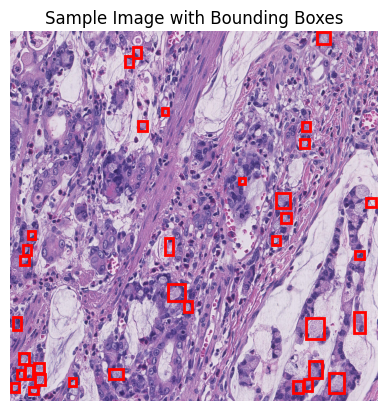

In [22]:
# Get image and target
image, target = dataset[0]
image_np = image.permute(1, 2, 0).numpy()

# Create plot
fig, ax = plt.subplots(1)
ax.imshow(image_np)
ax.set_title("Sample Image with Bounding Boxes")
ax.axis("off")

# Draw bounding boxes
for box in target['boxes']:
    xmin, ymin, xmax, ymax = box.tolist()
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

#### Add sliding window

In [23]:
class SignetRingCellPatchDataset(Dataset):
  def __init__(self, image_dir, annotation_dir, patch_size=512, transform=None):
    self.patch_size = patch_size
    self.stride = patch_size // 2
    self.transform = transform
    self.image_information = []

    # Loop over positive and negative folders
    for class_type in ['positive', 'negative']:
      full_image_dir = os.path.join(image_dir, class_type)
      full_anno_dir = os.path.join(annotation_dir, class_type)

      for fname in os.listdir(full_image_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
          # Collect image path
          image_path = os.path.join(full_image_dir, fname)

          # Collect annotation path
          if class_type == "positive":
            anno_filename = fname.replace('.png', '.xml').replace('.jpg', '.xml').replace('.jpeg', '.xml')
            anno_path = os.path.join(full_anno_dir, anno_filename)
          else:
            anno_path = None  # no annotation for negatives

          # Get the size of image
          image = Image.open(image_path)
          width, height = image.size

          # Generate sliding window patches
          for top in range(0, height - self.patch_size + 1, self.stride):
            for left in range(0, width - self.patch_size + 1, self.stride):
              self.image_information.append({
                  'image_path': image_path,
                  'annotation_path': anno_path,
                  'crop_box': (left, top, left + self.patch_size, top + self.patch_size)
              })

  def __len__(self):
    return len(self.image_information)

  def __getitem__(self, idx):
    # Get the cropped image
    image_info = self.image_information[idx]
    image = Image.open(image_info['image_path']).convert("RGB")
    crop_box = image_info['crop_box']
    image_patch = image.crop(crop_box)
    boxes_list, label_list = [], []

    if image_info['annotation_path'] is not None:
      tree = ET.parse(image_info['annotation_path'])
      root = tree.getroot()
      crop_xmin, crop_ymin, crop_xmax, crop_ymax = crop_box

      # Collect the bounding box
      for obj in root.findall('object'):
        name = obj.find('name').text
        if name == 'ring_cell_cancer':
          bbox = obj.find('bndbox')
          xmin = int(bbox.find('xmin').text)
          ymin = int(bbox.find('ymin').text)
          xmax = int(bbox.find('xmax').text)
          ymax = int(bbox.find('ymax').text)

          # Create new bounding box respect patching size
          if (xmin >= crop_xmin and xmax <= crop_xmax) and (ymin >= crop_ymin and ymax <= crop_ymax):
            new_xmin = max(xmin - crop_xmin, 0)
            new_ymin = max(ymin - crop_ymin, 0)
            new_xmax = min(xmax - crop_xmin, self.patch_size)
            new_ymax = min(ymax - crop_ymin, self.patch_size)
            boxes_list.append([new_xmin, new_ymin, new_xmax, new_ymax])
            label_list.append(1)

    # Handle both positive and negative samples
    if boxes_list:
        bounding_box = torch.tensor(boxes_list, dtype=torch.float32)
        label = torch.tensor(label_list, dtype=torch.int64)
    else:
        bounding_box = torch.zeros((0, 4), dtype=torch.float32)
        label = torch.zeros((0,), dtype=torch.int64)

    if self.transform:
      image_patch = self.transform(image_patch)

    target = {
        "boxes": bounding_box,
        "labels": label,
    }

    return image_patch, target

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/train"
annotation_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/annotations/train"

dataset = SignetRingCellPatchDataset(image_dir, annotation_dir, transform=transform)
image, target = dataset[0]

print(image.shape)
print(target)

torch.Size([3, 512, 512])
{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64)}


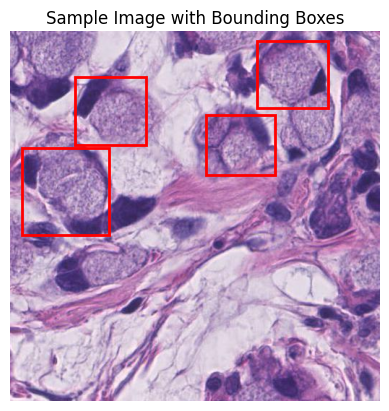

In [25]:
# Get image and target
image, target = dataset[300]
image_np = image.permute(1, 2, 0).numpy()

# Create plot
fig, ax = plt.subplots(1)
ax.imshow(image_np)
ax.set_title("Sample Image with Bounding Boxes")
ax.axis("off")

# Draw bounding boxes
for box in target['boxes']:
    xmin, ymin, xmax, ymax = box.tolist()
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

#### Add heatmap and regression

This code is implemented using the functions from [centernet-starterkit-pytorch](https://www.kaggle.com/code/zidanealdanifr/centernet-starterkit-pytorch)

In [26]:
# Make heatmaps using the utility functions from the centernet repo
# Draw a Gaussian centered at a point on a heatmap
def draw_msra_gaussian(heatmap, center, sigma=2):
  # Total size (radius) of the Gaussian region
  tmp_size = sigma * 6

  # Round the x and y center to nearest int
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)

  # Get heatmap dimensions
  w, h = heatmap.shape[0], heatmap.shape[1]

  # Upper-left and bottom-right corners of the Gaussian patch
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]

  # If Gaussian patch is completely outside the heatmap, return
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap

  # Create a 2D Gaussian
  size = 2 * tmp_size + 1 # Size of the Gaussian patch
  x = np.arange(0, size, 1, np.float32) # x coordinates
  y = x[:, np.newaxis] # y coordinates
  x0 = y0 = size // 2 # Center of the Gaussian
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) # 2D Gaussian formula

  # Compute valid bounds for placing the Gaussian patch on the heatmap
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)

  # Place the Gaussian on the heatmap using max to retain highest intensity
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])

  return heatmap

# Draw a dense regression value map around a center point
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  # Size of the square region
  diameter = 2 * radius + 1
  # Create Gaussian mask
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

  # Convert value to float32 and reshape to [dim, 1, 1]
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]

  # Create a repeated value map of shape [dim, H, W]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  # If it's an offset, adjust the values using distance from center
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)

  # Center coordinates
  x, y = int(center[0]), int(center[1])

  # Heatmap dimensions
  height, width = heatmap.shape[0:2]

  # Compute boundaries (clipping at image edges)
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  # Crop regions from heatmap, regmap, Gaussian, and value maps
  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  # Only update if region is valid (non-zero size)
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug

    # Create a mask where Gaussian is stronger than existing heatmap
    idx = (masked_gaussian >= masked_heatmap).reshape(1, masked_gaussian.shape[0],
                                                      masked_gaussian.shape[1])

    # Update regmap only where mask is True (using Gaussian gate)
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg

  # Write updated region back to original regmap
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap

  return regmap

def gaussian2D(shape, sigma=1):
    # Get center and coordinate grid
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    # Apply 2D Gaussian function
    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))

    # Remove near-zero values for stability
    h[h < np.finfo(h.dtype).eps * h.max()] = 0

    return h

def make_hm_regr(target, input_size=512, MODEL_SCALE=4):

    IN_SCALE = 1
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)
    # make regr heatmap
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)

    if target.empty:
        return hm, regr

    center = np.array([target["x"] + target["w"]//2, target["y"] + target["h"]//2,
                       target["w"], target["h"]]).T

    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE,
                                     int(c[1])//MODEL_SCALE//IN_SCALE],
                                sigma=np.clip(c[2]*c[3]//2000, 2, 4))

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i,
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;

    return hm, regr

def pred2box(hm, regr, thresh=0.99, MODEL_SCALE=4, input_size=512):
    pred = hm > thresh
    pred_center = np.where(pred)
    pred_r = regr[:, pred].T  # Shape: [N, 2] for w, h
    boxes = []
    scores = hm[pred]

    for i, b in enumerate(pred_r):
        cx = pred_center[1][i] * MODEL_SCALE
        cy = pred_center[0][i] * MODEL_SCALE

        w = b[0] * input_size
        h = b[1] * input_size

        x1 = cx - w /2
        y1 = cy - h /2

        arr = np.clip([x1, y1, w, h], 0, input_size)
        boxes.append(arr)

    return np.asarray(boxes), scores


# Assuming `image` is a torch.Tensor of shape (3, H, W)
def unnormalize_tensor(image):
  mean = [0.485, 0.456, 0.406]
  std  = [0.229, 0.224, 0.225]
  for t, m, s in zip(image, mean, std):
    t.mul_(s).add_(m)
  return image

In [27]:
class SignetRingCellPatchCenterNetDataset(Dataset):
  def __init__(self, image_dir, annotation_dir, patch_size=512, transform=None):
    # Initialize parameters
    self.patch_size = patch_size
    self.stride = patch_size//2  # 50% overlap for 512x512 patches
    self.transform = transform
    self.image_information = []

    # Loop over positive and negative folders
    for class_type in ['positive']:
      full_image_dir = os.path.join(image_dir, class_type)
      full_anno_dir = os.path.join(annotation_dir, class_type)

      # Iterate over image files in the folder
      for fname in os.listdir(full_image_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
          # Collect image path
          image_path = os.path.join(full_image_dir, fname)

          # Collect annotation path
          if class_type == "positive":
            anno_filename = fname.replace('.png', '.xml').replace('.jpg', '.xml').replace('.jpeg', '.xml')
            anno_path = os.path.join(full_anno_dir, anno_filename)
          else:
            anno_path = None  # no annotation for negatives

          # Get the size of image
          image = cv2.imread(image_path)
          height, width = image.shape[:2]

          # Generate sliding window patches
          for top in range(0, height - self.patch_size + 1, self.stride):
            for left in range(0, width - self.patch_size + 1, self.stride):
              self.image_information.append({
                  'image_path': image_path,
                  'annotation_path': anno_path,
                  'crop_box': (left, top, left + self.patch_size, top + self.patch_size)
              })

  def __len__(self):
    return len(self.image_information) # Total number of patches

  def __getitem__(self, idx):
    # Get image for this index
    image_info = self.image_information[idx]
    image = cv2.imread(image_info['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crop patch using numpy slicing: [top:bottom, left:right]
    left, top, right, bottom = image_info['crop_box']
    image_patch = image[top:bottom, left:right]

    # Load and process annotations
    boxes_list = []
    if image_info['annotation_path'] is not None:
        tree = ET.parse(image_info['annotation_path'])
        root = tree.getroot()

        crop_xmin, crop_ymin, crop_xmax, crop_ymax = image_info['crop_box']
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == 'ring_cell_cancer':
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                if (xmin >= crop_xmin and xmax <= crop_xmax) and (ymin >= crop_ymin and ymax <= crop_ymax):
                    new_xmin = xmin - crop_xmin
                    new_ymin = ymin - crop_ymin
                    new_xmax = xmax - crop_xmin
                    new_ymax = ymax - crop_ymin
                    boxes_list.append((new_xmin, new_ymin,
                                       new_xmax - new_xmin,
                                       new_ymax - new_ymin))

    # Generate heatmap and regression map as before
    if len(boxes_list) == 0:
        hm = np.zeros([self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
        regr = np.zeros([2, self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
    else:
        target = pd.DataFrame(boxes_list, columns=['x', 'y', 'w', 'h'])
        hm, regr  = make_hm_regr(target)

    # Apply transforms if any
    if self.transform:
        image_patch = self.transform(image_patch)

    return image_patch, hm, regr, boxes_list

In [28]:
# Transform function
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy to PIL
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Path of dataset
image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/train"
annotation_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/annotations/train"

# Load dataset and patching
dataset = SignetRingCellPatchCenterNetDataset(image_dir, annotation_dir, transform=transform)
image_patch, hm, regr, boxes_list = dataset[0]

print(image_patch.shape)

torch.Size([3, 512, 512])


torch.Size([3, 512, 512])


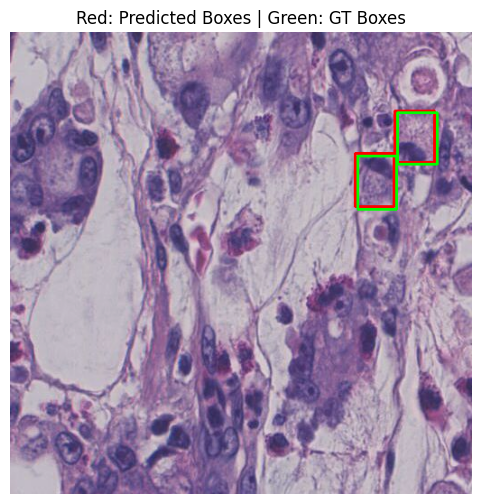

In [29]:
# Get image
image, hm, regr, gt_boxes = dataset[1]
print(image.shape)
image = unnormalize_tensor(image.clone())

# Get predicted boxes
pred_boxes, _ = pred2box(hm, regr)

# Convert image to numpy
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Make a copy for drawing
image_copy = image.copy()

# Draw predicted boxes (red)
for box in pred_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw GT boxes (green)
for box in gt_boxes:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Display
plt.figure(figsize=(6, 6))
plt.imshow(image_copy)
plt.title("Red: Predicted Boxes | Green: GT Boxes")
plt.axis("off")
plt.show()

### 3.2 DataLoader

In [32]:
# Transform function
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy to PIL
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Paths
dataset_base_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset"

# Train and Validation dataset
full_train_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "train"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/train"),
    transform=transform
)

# 90% training, 10% validation
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Test dataset
test_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "test"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/test"),
    transform=transform
)

# Define a custom collate function to handle the variable-length gt_boxes
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    hms = torch.stack([torch.from_numpy(item[1]).float() for item in batch])
    regrs = torch.stack([torch.from_numpy(item[2]).float() for item in batch])
    gt_boxes = [item[3] for item in batch]

    return images, hms, regrs, gt_boxes

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

#### Check `train_loader` function

In [59]:
for batch in train_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 32 images


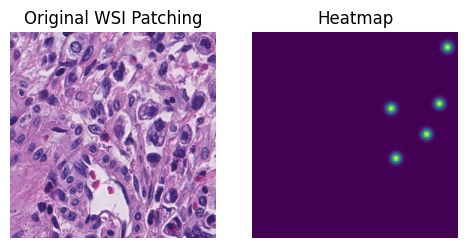

In [60]:
# Convert image to numpy
image = unnormalize_tensor(images[30].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Show the original image
axs[0].imshow(image)
axs[0].set_title("Original WSI Patching")
axs[0].axis('off')

# Show the heatmap
axs[1].imshow(hm[30])  # or use 'viridis', 'jet', etc.
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

#### Check `val_loader` function

In [61]:
for batch in val_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 32 images


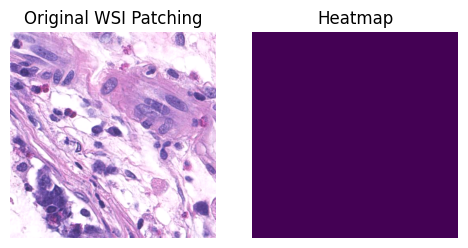

In [62]:
# Convert image to numpy
image = unnormalize_tensor(images[30].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Show the original image
axs[0].imshow(image)
axs[0].set_title("Original WSI Patching")
axs[0].axis('off')

# Show the heatmap
axs[1].imshow(hm[30])  # or use 'viridis', 'jet', etc.
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

#### Check `test_loader` function

In [63]:
for batch in test_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 32 images


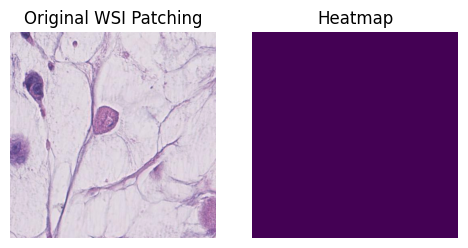

In [64]:
# Convert image to numpy
image = unnormalize_tensor(images[30].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Show the original image
axs[0].imshow(image)
axs[0].set_title("Original WSI Patching")
axs[0].axis('off')

# Show the heatmap
axs[1].imshow(hm[30])  # or use 'viridis', 'jet', etc.
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()